In [3]:
# C-MAPSS RUL预测：CNN+LSTM vs CNN+Transformer 模型比较
# 基于PyTorch和Hugging Face实现

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import os
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)
seq_length=30
EPOCHS = 30


使用设备: cpu


In [2]:
# 定义数据集和数据预处理函数
class CMAPSSDataset(Dataset):
    """C-MAPSS数据集的自定义Dataset类"""
    
    def __init__(self, data, labels, seq_length=30):
        self.data = data
        self.labels = labels
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

In [3]:
def load_cmapss_data(dataset_num=1):
    """
    加载C-MAPSS数据集
    
    参数:
    - dataset_num: 使用的子数据集编号 (1-4)
    
    返回:
    - 训练数据, 训练标签, 测试数据, 测试标签
    """
    # 假设数据文件位于当前目录下的'CMAPSSData'子目录中
    train_file = f'./CMAPSSData/train_FD00{dataset_num}.txt'
    test_file = f'./CMAPSSData/test_FD00{dataset_num}.txt'
    rul_file = f'./CMAPSSData/RUL_FD00{dataset_num}.txt'
    
    # 读取数据
    train_df = pd.read_csv(train_file, sep=' ', header=None).drop([26, 27], axis=1)
    test_df = pd.read_csv(test_file, sep=' ', header=None).drop([26, 27], axis=1)
    rul_df = pd.read_csv(rul_file, sep=' ', header=None).drop([1], axis=1)
    
    # 为列命名
    columns = ['unit', 'cycle', 'op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
    train_df.columns = columns
    test_df.columns = columns
    
    # 提取特征并标准化
    # 使用运行工况和传感器读数作为特征
    feature_cols = ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]
    
    # 训练数据的处理
    train_units = train_df['unit'].unique()
    train_data, train_labels = [], []
    
    # 计算训练集中每个单元的最大周期数（用于计算RUL）
    max_cycles = train_df.groupby('unit')['cycle'].max().to_dict()
    
    # 标准化所有特征
    scaler = MinMaxScaler()
    train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
    test_df[feature_cols] = scaler.transform(test_df[feature_cols])
    
    # 处理训练数据
    for unit in train_units:
        unit_data = train_df[train_df['unit'] == unit]
        
        # 计算RUL标签 (这里使用线性下降RUL)
        unit_data['RUL'] = max_cycles[unit] - unit_data['cycle']
        
        # 创建序列数据
        for i in range(len(unit_data) - seq_length + 1):
            seq_data = unit_data.iloc[i:i+seq_length][feature_cols].values
            seq_label = unit_data.iloc[i+seq_length-1]['RUL']
            
            train_data.append(seq_data)
            train_labels.append(seq_label)
    
    # 测试数据的处理
    test_units = test_df['unit'].unique()
    test_data, test_labels = [], []
    
    # 读取测试集的真实RUL值
    true_rul = rul_df[0].values
    
    for i, unit in enumerate(test_units):
        unit_data = test_df[test_df['unit'] == unit]
        
        # 对于测试集，我们使用最后seq_length个周期来预测
        if len(unit_data) >= seq_length:
            test_seq = unit_data.iloc[-seq_length:][feature_cols].values
        else:
            # 如果数据不足seq_length，则用0填充
            pad_length = seq_length - len(unit_data)
            pad = np.zeros((pad_length, len(feature_cols)))
            unit_seq = unit_data[feature_cols].values
            test_seq = np.vstack((pad, unit_seq))
        
        test_data.append(test_seq)
        test_labels.append(true_rul[i])
    
    # 转换为numpy数组
    train_data = np.array(train_data, dtype=np.float32)
    train_labels = np.array(train_labels, dtype=np.float32)
    test_data = np.array(test_data, dtype=np.float32)
    test_labels = np.array(test_labels, dtype=np.float32)
    
    # 将数据转换为Tensor
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1)
    
    # 将数据划分为训练集和验证集
    indices = torch.randperm(len(train_data))
    split = int(0.8 * len(train_data))
    train_indices = indices[:split]
    val_indices = indices[split:]
    
    val_data = train_data[val_indices]
    val_labels = train_labels[val_indices]
    train_data = train_data[train_indices]
    train_labels = train_labels[train_indices]
    
    return train_data, train_labels, val_data, val_labels, test_data, test_labels



In [4]:
# 加载数据集（使用数据集FD001）
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_cmapss_data(dataset_num=1)

print(f"训练数据形状: {train_data.shape}")
print(f"验证数据形状: {val_data.shape}")
print(f"测试数据形状: {test_data.shape}")

# 创建DataLoader
batch_size = 64
train_dataset = CMAPSSDataset(train_data, train_labels)
val_dataset = CMAPSSDataset(val_data, val_labels)
test_dataset = CMAPSSDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


训练数据形状: torch.Size([14184, 30, 24])
验证数据形状: torch.Size([3547, 30, 24])
测试数据形状: torch.Size([100, 30, 24])


In [16]:
# 模型一：CNN + LSTM
class CNN_LSTM(nn.Module):
    def __init__(self, input_channels, seq_length, hidden_size=64, num_layers=2):
        super(CNN_LSTM, self).__init__()
        
        # 第一层卷积
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        
        # 第二层卷积
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(64)
        
        # LSTM层
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, 
                           num_layers=num_layers, batch_first=True)
        
        # 全连接输出层
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # 输入x的形状: [batch_size, seq_length, input_channels]
        # 转换为卷积1D需要的形状: [batch_size, input_channels, seq_length]
        x = x.permute(0, 2, 1)
        
        # 应用第一层卷积
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        
        # 应用第二层卷积
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        
        # 转换为LSTM需要的形状: [batch_size, seq_length, features]
        x = x.permute(0, 2, 1)
        
        # 应用LSTM层
        output, _ = self.lstm(x)
        
        # 使用最后一个时间步的输出做预测
        x = output[:, -1, :]
        
        # 全连接层输出
        x = self.fc(x)
        
        return x


In [4]:
# 从transformers库导入必要的包
from transformers import BertConfig

# 模型二：CNN + Transformer
class CNN_Transformer(nn.Module):
    def __init__(self, input_channels, seq_length, hidden_size=64, num_heads=8, num_layers=4):
        super(CNN_Transformer, self).__init__()
        
        # 第一层卷积
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        
        # 第二层卷积
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(64)
        
        # 位置编码（可选，但对Transformer通常有帮助）
        self.positional_encoding = nn.Parameter(
            torch.zeros(1, seq_length, 64)
        )
        
        # 使用BertConfig配置并创建Transformer编码器层
        self.transformer_config = BertConfig(
            hidden_size=64,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=128,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1
        )
        
        # 创建自定义的Transformer编码器 
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, 
            nhead=num_heads,
            dim_feedforward=128,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, 
            num_layers=num_layers
        )
        
        # 全连接输出层
        self.fc = nn.Linear(64, 1)
    
    def forward(self, x):
        # 输入x的形状: [batch_size, seq_length, input_channels]
        # 转换为卷积1D需要的形状: [batch_size, input_channels, seq_length]
        x = x.permute(0, 2, 1)
        
        # 应用第一层卷积
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        
        # 应用第二层卷积
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        
        # 转换为Transformer需要的形状: [batch_size, seq_length, features]
        x = x.permute(0, 2, 1)
        
        # 添加位置编码
        x = x + self.positional_encoding
        
        # 应用Transformer编码器
        x = self.transformer_encoder(x)
        
        # 使用最后一个时间步的输出做预测
        x = x[:, -1, :]
        
        # 全连接层输出
        x = self.fc(x)
        
        return x


In [7]:
# 训练函数
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, targets))
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        # 计算平均训练损失
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # 前向传播
                outputs = model(inputs)
                loss = torch.sqrt(criterion(outputs, targets))
                
                val_loss += loss.item() * inputs.size(0)
            
        # 计算平均验证损失
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses


In [8]:
# 评估函数
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    test_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            
            predictions.extend(outputs.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())
    
    # 计算RMSE
    predictions = np.array(predictions)
    test_targets = np.array(test_targets)
    rmse = np.sqrt(mean_squared_error(test_targets, predictions))
    
    return rmse, predictions, test_targets


In [9]:
# 实例化模型
input_channels = train_data.shape[2]  # 特征数
seq_length = train_data.shape[1]      # 序列长度

# 创建CNN+LSTM模型
cnn_lstm_model = CNN_LSTM(
    input_channels=input_channels, 
    seq_length=seq_length
).to(device)

# 创建CNN+Transformer模型
cnn_transformer_model = CNN_Transformer(
    input_channels=input_channels, 
    seq_length=seq_length
).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()  # RMSE通过MSE计算
lstm_optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=0.001)
transformer_optimizer = optim.Adam(cnn_transformer_model.parameters(), lr=0.001)


In [10]:
# 训练CNN+LSTM模型
print("\n训练CNN+LSTM模型...")
lstm_train_losses, lstm_val_losses = train_model(
    cnn_lstm_model, 
    train_loader, 
    val_loader, 
    lstm_optimizer, 
    criterion, 
    num_epochs=EPOCHS
)



训练CNN+LSTM模型...
Epoch 1/30, Train Loss: 103.1333, Val Loss: 98.0878
Epoch 2/30, Train Loss: 91.0193, Val Loss: 87.2174
Epoch 3/30, Train Loss: 80.5650, Val Loss: 77.2395
Epoch 4/30, Train Loss: 71.1014, Val Loss: 68.4127
Epoch 5/30, Train Loss: 62.7457, Val Loss: 60.8113
Epoch 6/30, Train Loss: 55.4497, Val Loss: 53.9506
Epoch 7/30, Train Loss: 49.1466, Val Loss: 47.9068
Epoch 8/30, Train Loss: 43.9991, Val Loss: 43.9544
Epoch 9/30, Train Loss: 39.9899, Val Loss: 39.7036
Epoch 10/30, Train Loss: 36.7421, Val Loss: 36.8816
Epoch 11/30, Train Loss: 34.3745, Val Loss: 34.7177
Epoch 12/30, Train Loss: 32.5195, Val Loss: 33.8138
Epoch 13/30, Train Loss: 30.9858, Val Loss: 32.3666
Epoch 14/30, Train Loss: 29.6329, Val Loss: 30.5756
Epoch 15/30, Train Loss: 28.3597, Val Loss: 29.5118
Epoch 16/30, Train Loss: 27.1378, Val Loss: 28.1545
Epoch 17/30, Train Loss: 26.1864, Val Loss: 26.0228
Epoch 18/30, Train Loss: 24.3763, Val Loss: 25.6770
Epoch 19/30, Train Loss: 23.3354, Val Loss: 24.5477
Epo

In [11]:
# 训练CNN+Transformer模型
print("\n训练CNN+Transformer模型...")
transformer_train_losses, transformer_val_losses = train_model(
    cnn_transformer_model, 
    train_loader, 
    val_loader, 
    transformer_optimizer, 
    criterion, 
    num_epochs=EPOCHS
)



训练CNN+Transformer模型...
Epoch 1/30, Train Loss: 99.9884, Val Loss: 89.3082
Epoch 2/30, Train Loss: 71.7842, Val Loss: 56.9903
Epoch 3/30, Train Loss: 43.7491, Val Loss: 36.4372
Epoch 4/30, Train Loss: 32.5439, Val Loss: 30.9286
Epoch 5/30, Train Loss: 29.2715, Val Loss: 29.1466
Epoch 6/30, Train Loss: 25.6616, Val Loss: 23.5354
Epoch 7/30, Train Loss: 21.1875, Val Loss: 18.0285
Epoch 8/30, Train Loss: 16.6083, Val Loss: 15.8820
Epoch 9/30, Train Loss: 13.5378, Val Loss: 12.2587
Epoch 10/30, Train Loss: 11.5488, Val Loss: 11.5500
Epoch 11/30, Train Loss: 9.9285, Val Loss: 7.9309
Epoch 12/30, Train Loss: 9.1109, Val Loss: 7.6229
Epoch 13/30, Train Loss: 8.5009, Val Loss: 7.8098
Epoch 14/30, Train Loss: 7.4587, Val Loss: 7.0926
Epoch 15/30, Train Loss: 6.9257, Val Loss: 6.1878
Epoch 16/30, Train Loss: 6.6580, Val Loss: 6.7001
Epoch 17/30, Train Loss: 6.3820, Val Loss: 6.0138
Epoch 18/30, Train Loss: 5.9930, Val Loss: 4.9334
Epoch 19/30, Train Loss: 5.6814, Val Loss: 5.0799
Epoch 20/30, Tr

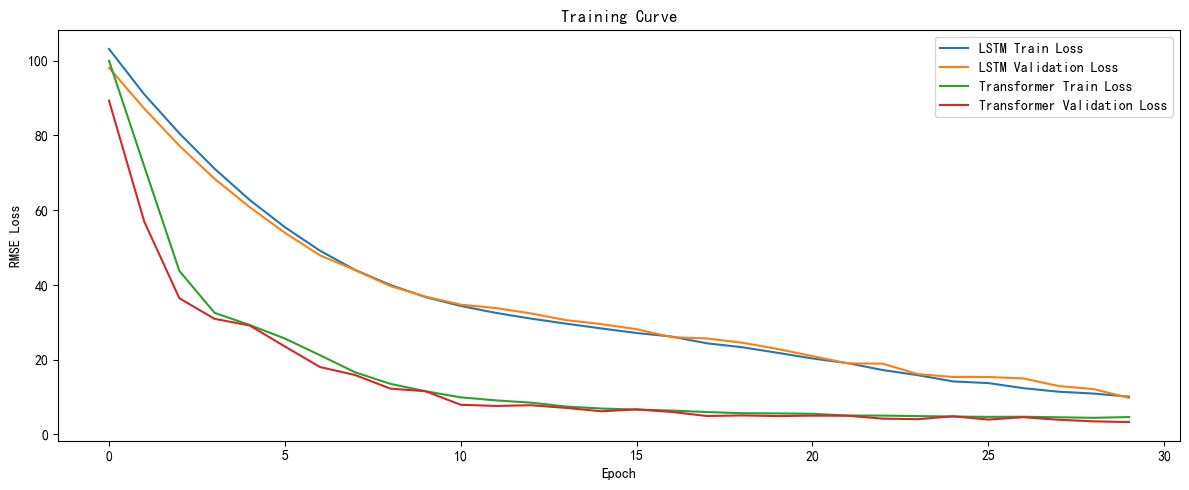

In [12]:
# 绘制训练曲线
plt.figure(figsize=(12, 5))

# LSTM训练曲线
#plt.subplot(1, 2, 1)
plt.plot(lstm_train_losses, label='LSTM Train Loss')
plt.plot(lstm_val_losses, label='LSTM Validation Loss')
plt.plot(transformer_train_losses, label='Transformer Train Loss')
plt.plot(transformer_val_losses, label='Transformer Validation Loss')
plt.title('Training Curve')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.legend()

plt.tight_layout()
plt.show()


模型评估...
CNN+LSTM模型的测试RMSE: 27.5377
CNN+Transformer模型的测试RMSE: 25.4414


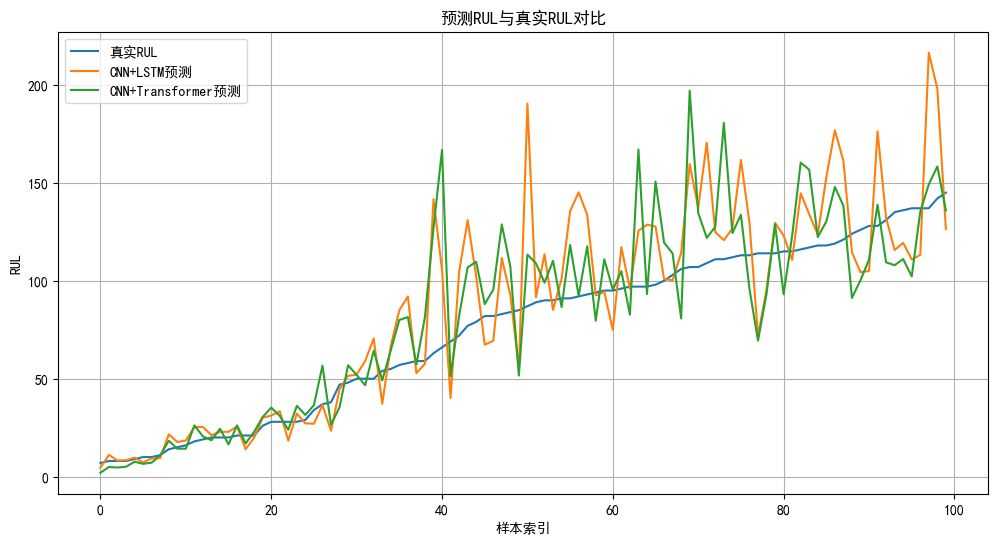

In [13]:
# 评估两个模型
print("\n模型评估...")
lstm_rmse, lstm_preds, lstm_targets = evaluate_model(cnn_lstm_model, test_loader)
transformer_rmse, transformer_preds, transformer_targets = evaluate_model(cnn_transformer_model, test_loader)

print(f"CNN+LSTM模型的测试RMSE: {lstm_rmse:.4f}")
print(f"CNN+Transformer模型的测试RMSE: {transformer_rmse:.4f}")

# 可视化对比预测结果
plt.figure(figsize=(12, 6))

# 按照测试样本索引排序预测和真实值
idx = np.argsort(lstm_targets.flatten())
lstm_preds_sorted = lstm_preds[idx].flatten()
transformer_preds_sorted = transformer_preds[idx].flatten()
targets_sorted = lstm_targets[idx].flatten()

plt.plot(targets_sorted, label='真实RUL')
plt.plot(lstm_preds_sorted, label='CNN+LSTM预测')
plt.plot(transformer_preds_sorted, label='CNN+Transformer预测')
plt.title('预测RUL与真实RUL对比')
plt.xlabel('样本索引')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# 比较两个模型的性能差异
if lstm_rmse < transformer_rmse:
    improvement = (transformer_rmse - lstm_rmse) / transformer_rmse * 100
    print(f"\nCNN+LSTM模型性能更优，相比CNN+Transformer模型RMSE降低了{improvement:.2f}%")
else:
    improvement = (lstm_rmse - transformer_rmse) / lstm_rmse * 100
    print(f"\nCNN+Transformer模型性能更优，相比CNN+LSTM模型RMSE降低了{improvement:.2f}%")

# 结果摘要和分析
print("\n=== 结果摘要 ===")
print(f"CNN+LSTM模型的测试RMSE: {lstm_rmse:.4f}")
print(f"CNN+Transformer模型的测试RMSE: {transformer_rmse:.4f}")
print("\n性能分析：")
if lstm_rmse < transformer_rmse:
    print("在此实验中，CNN+LSTM模型表现更好，可能的原因包括：")
    print("1. LSTM更适合捕捉时序数据中的长期依赖关系")
    print("2. 对于RUL预测任务，序列的顺序信息对模型至关重要")
    print("3. 本实验的数据量和序列长度可能更适合LSTM模型")
else:
    print("在此实验中，CNN+Transformer模型表现更好，可能的原因包括：")
    print("1. Transformer的自注意力机制能够更好地捕捉特征间的关联")
    print("2. Transformer对于处理并行序列数据更有效")
    print("3. Transformer的注意力机制可以关注到序列中的重要部分")

print("\n改进建议：")
print("1. 尝试调整模型超参数，如隐藏层大小、注意力头数量等")
print("2. 使用更复杂的特征工程方法来预处理数据")
print("3. 考虑使用集成学习方法结合两种模型的优势")
print("4. 尝试更长的训练周期或不同的学习率调度策略")



CNN+Transformer模型性能更优，相比CNN+LSTM模型RMSE降低了7.61%

=== 结果摘要 ===
CNN+LSTM模型的测试RMSE: 27.5377
CNN+Transformer模型的测试RMSE: 25.4414

性能分析：
在此实验中，CNN+Transformer模型表现更好，可能的原因包括：
1. Transformer的自注意力机制能够更好地捕捉特征间的关联
2. Transformer对于处理并行序列数据更有效
3. Transformer的注意力机制可以关注到序列中的重要部分

改进建议：
1. 尝试调整模型超参数，如隐藏层大小、注意力头数量等
2. 使用更复杂的特征工程方法来预处理数据
3. 考虑使用集成学习方法结合两种模型的优势
4. 尝试更长的训练周期或不同的学习率调度策略


In [5]:
from torchviz import make_dot

# 构建模型和示例输入
model = CNN_Transformer(input_channels=24, seq_length=30)
sample_input = torch.randn(1, 30, 24)
output = model(sample_input)

# 生成计算图
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = "png"
dot.render("CNN_Transformer_Model")

'CNN_Transformer_Model.png'

In [17]:
from torchinfo import summary

model = CNN_LSTM(input_channels=24, seq_length=30)
summary(model, input_size=(1, 30, 24))  # (T, F)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_LSTM                                 [1, 1]                    --
├─Conv1d: 1-1                            [1, 64, 30]               4,672
├─ReLU: 1-2                              [1, 64, 30]               --
├─BatchNorm1d: 1-3                       [1, 64, 30]               128
├─Conv1d: 1-4                            [1, 64, 30]               12,352
├─ReLU: 1-5                              [1, 64, 30]               --
├─BatchNorm1d: 1-6                       [1, 64, 30]               128
├─LSTM: 1-7                              [1, 30, 64]               66,560
├─Linear: 1-8                            [1, 1]                    65
Total params: 83,905
Trainable params: 83,905
Non-trainable params: 0
Total mult-adds (M): 2.51
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.34
Estimated Total Size (MB): 0.42

In [14]:
from torchinfo import summary

model = CNN_Transformer(input_channels=24, seq_length=30)
summary(model, input_size=(1, 30, 24))  # (T, F)

Layer (type:depth-idx)                        Output Shape              Param #
CNN_Transformer                               [1, 1]                    35,392
├─Conv1d: 1-1                                 [1, 64, 30]               4,672
├─ReLU: 1-2                                   [1, 64, 30]               --
├─BatchNorm1d: 1-3                            [1, 64, 30]               128
├─Conv1d: 1-4                                 [1, 64, 30]               12,352
├─ReLU: 1-5                                   [1, 64, 30]               --
├─BatchNorm1d: 1-6                            [1, 64, 30]               128
├─TransformerEncoder: 1-7                     [1, 30, 64]               --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 30, 64]               33,472
│    │    └─TransformerEncoderLayer: 3-2      [1, 30, 64]               33,472
│    │    └─TransformerEncoderLayer: 3-3      [1, 30, 64]               33